<a href="https://colab.research.google.com/github/wenqiglantz/hands-on-llamaindex/blob/main/03_edd_llms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation-Driven Development (EDD) for Multi Document RAG Pipeline with GPT-3.5 and Zephyr-7b-beta

This notebook demonstrates how to use EDD to decide which of the two LLMs perform best for a multi document RAG pipeline for Metadata replacement + node sentence window:


*   gpt-3.5-turbo
*   zephyr-7b-beta

Suggest to upgrade to Colab Pro to run on T4 high-RAM. I tried to run on the free tier T4 GPU but failed during the download of Zephyr-7b-beta.


## Why EDD?

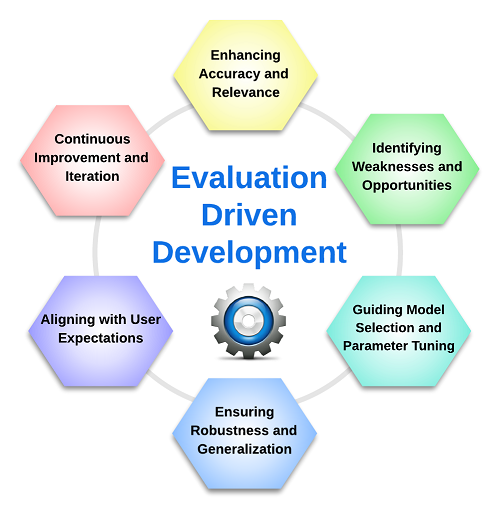

* **Enhancing Accuracy and Relevance**: EDD helps in identifying and addressing potential issues with the pipeline's output, ensuring that the generated responses are accurate, relevant, and consistent with the provided context.

* **Identifying Weaknesses and Opportunities**: EDD facilitates the detection of areas where the pipeline can be improved, allowing developers to focus on specific aspects that require refinement. This continuous evaluation process leads to overall performance optimization.

* **Guiding Model Selection and Parameter Tuning**: By evaluating different models and parameter configurations, EDD guides the selection of the most suitable model architecture and hyperparameters for the specific task at hand.

* **Ensuring Robustness and Generalization**: EDD ensures that the pipeline performs consistently across a variety of input scenarios and data distributions, enhancing its robustness and generalization capabilities.

* **Aligning with User Expectations**: EDD helps in aligning the pipeline's output with user expectations and requirements, ensuring that the generated responses are tailored to the specific needs of the target audience.

* **Continuous Improvement and Iteration**: EDD promotes a culture of continuous improvement and iteration, enabling developers to make informed decisions based on objective evaluation metrics.

In summary, EDD facilitates continuous improvement and optimization, and it plays a critical role in the development of high-quality RAG pipelines by ensuring that the generated responses are accurate, relevant, and aligned with user expectations.

## How to Implement EDD?

1. Use DatasetGenerator to auto-generate evaluation questions.
2. Define evaluators for faithfulness, relevancy, etc.
3. Use BatchEvalRunner to asynchronously run evaluations of the responses.
4. Compare the evaluation results.


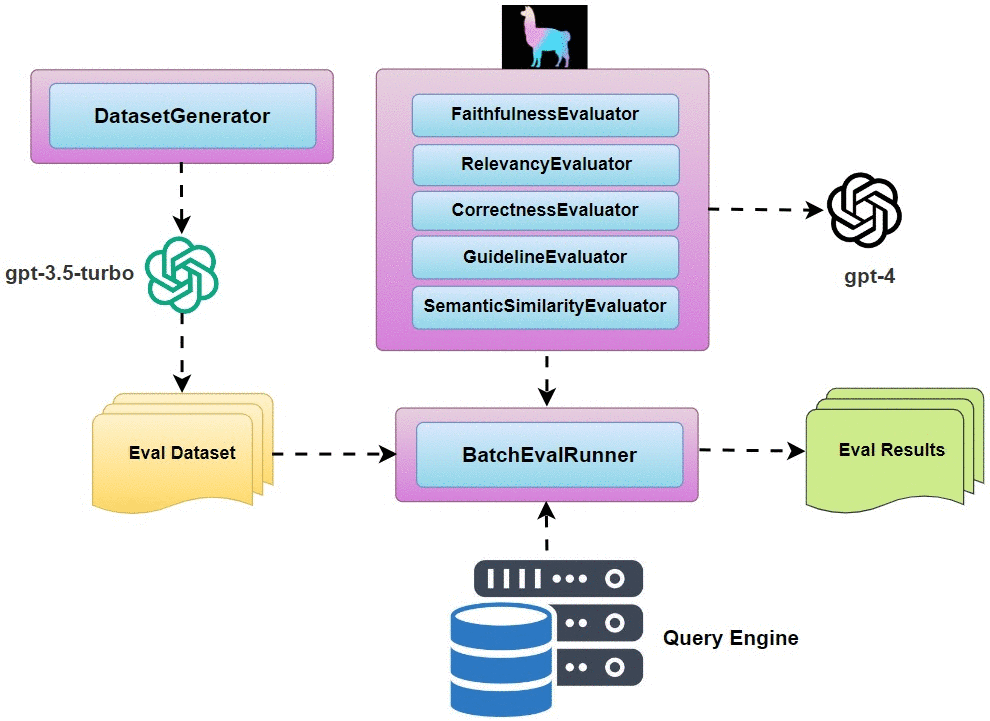

In [1]:
%pip install -q llama-index-embeddings-openai
%pip install -q llama-index-embeddings-huggingface
%pip install -q llama-index-llms-openai
%pip install -q llama-index-llms-huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -q llama_index pypdf sentence-transformers transformers accelerate bitsandbytes

## POC with Metadata Replacement + Node Sentence Window

SentenceWindowNodeParser is a tool that can be used to create representations of sentences that consider the surrounding words and sentences. During retrieval, before passing the retrieved sentences to the LLM, the single sentences are replaced with a window containing the surrounding sentences using the MetadataReplacementNodePostProcessor. This can be useful for tasks such as machine translation or summarization, where it is essential to understand the meaning of the sentence in its entirety. This is most useful for large documents, as it helps to retrieve more fine-grained details.

### Load documents

In [ ]:
import logging, sys
import nest_asyncio

nest_asyncio.apply()

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [ ]:
from llama_index.core import SimpleDirectoryReader

titles = [
    "DevOps_Self-Service_Pipeline_Architecture",
    "DevOps_Self-Service_Terraform_Project_Structure",
    "DevOps_Self-Service_Pipeline_Security_Guardrails"
    ]

documents = {}
for title in titles:
    documents[title] = SimpleDirectoryReader(input_files=[f"./data/{title}.pdf"]).load_data()
print(f"loaded documents with {len(documents)} documents")

loaded documents with 3 documents


### Set up node parser

In [ ]:
from llama_index.core import set_global_service_context
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SentenceWindowNodeParser, SimpleNodeParser

# create the sentence window node parser
node_parser = SentenceWindowNodeParser.from_defaults(
    window_size=3,
    window_metadata_key="window",
    original_text_metadata_key="original_text",
)
simple_node_parser = SimpleNodeParser.from_defaults()

## gpt-3.5-turbo

### Extract nodes and build index

In [ ]:
import os
from google.colab import userdata

# set OpenAI API key in environment variable
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

In [ ]:
#define LLM and embedding model
llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1)
embed_model = "local:BAAI/bge-base-en-v1.5"

from llama_index.core import VectorStoreIndex

# extract nodes and build index
document_list = SimpleDirectoryReader("data").load_data()
nodes = node_parser.get_nodes_from_documents(document_list)
sentence_index = VectorStoreIndex(nodes, embed_model=embed_model)

### Define query engine

In [ ]:
from llama_index.core.postprocessor import MetadataReplacementPostProcessor

metadata_query_engine = sentence_index.as_query_engine(
    similarity_top_k=2,
    llm=llm,
    # the target key defaults to `window` to match the node_parser's default
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window")
    ]
)

### Run test queries

In [ ]:
response = metadata_query_engine.query("Give me a summary of DevOps self-service-centric pipeline security and guardrails.")
print(str(response))

DevOps self-service-centric pipeline security and guardrails involve implementing security measures and guidelines for pipelines, infrastructure, source code, base images, and dependent libraries. These security measures are hand-picked actions that aim to ensure the security and integrity of the DevOps self-service environment. By implementing these guardrails, organizations can mitigate risks and protect their systems from potential vulnerabilities.


In [ ]:
response = metadata_query_engine.query("What is Harden Runner in DevOps self-service-centric pipeline security and guardrails?")
print(str(response))

Harden-Runner is a purpose-built security monitoring agent used in DevOps self-service-centric pipeline security and guardrails. It automatically discovers and correlates outbound traffic with each step in the pipeline, preventing the exfiltration of credentials. It is the only action used in all pipelines, including infrastructure and application pipelines for both CI and CD workflows.


## zephyr-7b-beta

In [ ]:
import torch
from transformers import BitsAndBytesConfig
from llama_index.core import PromptTemplate
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core import set_global_tokenizer

# load a model in 4bit using NF4 quantization with double quantization with the compute dtype bfloat16 for faster training
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

try:
    llm_zephyr = HuggingFaceLLM(
        model_name="HuggingFaceH4/zephyr-7b-beta",
        tokenizer_name="HuggingFaceH4/zephyr-7b-beta",
        query_wrapper_prompt=PromptTemplate(
            "<|system|>\n</s>\n<|user|>\n{query_str}</s>\n<|assistant|>\n"
        ),
        context_window=3900,
        max_new_tokens=256,
        model_kwargs={"quantization_config": quantization_config},
        generate_kwargs={
            "do_sample": True,
            "temperature": 0.7,
            "top_k": 50,
            "top_p": 0.95,
        },
        device_map="auto",
    )
except Exception:
    print(
        "Failed to load and quantize model, likely due to CUDA being missing. "
        "Loading full precision model instead."
    )
    llm_zephyr = HuggingFaceLLM(
        model_name="HuggingFaceH4/zephyr-7b-beta",
        tokenizer_name="HuggingFaceH4/zephyr-7b-beta",
        query_wrapper_prompt=PromptTemplate(
            "<|system|>\n</s>\n<|user|>\n{query_str}</s>\n<|assistant|>\n"
        ),
        context_window=3900,
        max_new_tokens=256,
        generate_kwargs={
            "do_sample": True,
            "temperature": 0.7,
            "top_k": 50,
            "top_p": 0.95,
        },
        device_map="auto",
    )

# set tokenizer for proper token counting
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceH4/zephyr-7b-beta")
set_global_tokenizer(tokenizer.encode)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

### Extract nodes and build index

In [ ]:
from llama_index.core import VectorStoreIndex

document_list = SimpleDirectoryReader("data").load_data()
nodes = node_parser.get_nodes_from_documents(document_list)
sentence_index_zephyr = VectorStoreIndex(nodes, embed_model="local:BAAI/bge-base-en-v1.5")

### Define query engine

In [ ]:
from llama_index.core.postprocessor import MetadataReplacementPostProcessor

metadata_query_engine_zephyr = sentence_index_zephyr.as_query_engine(
    similarity_top_k=2,
    llm=llm_zephyr,
    # the target key defaults to `window` to match the node_parser's default
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window")
    ]
)

### Run test queries

In [ ]:
query = "Give me a summary of DevOps self-service-centric pipeline security and guardrails."
response = metadata_query_engine_zephyr.query(query)
print(str(response))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The article discusses the topic of DevOps self-service-centric pipeline security and guardrails, providing a list of recommended actions for security scans and safeguards for pipelines, infrastructure, source code, base images, and dependent libraries. The author acknowledges that some readers may still be hesitant about security measures in this context, having come from a traditional DevOps mindset. The article builds upon previous articles on DevOps self-service pipeline architecture, Terraform project structure, and GitHub Actions workflow orchestration. The summary highlights the focus on security measures and safeguards for DevOps self-service pipelines.


In [ ]:
query = "What is Harden Runner in DevOps self-service-centric pipeline security and guardrails?"
response = metadata_query_engine_zephyr.query(query)
print(str(response))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Harden Runner is a security monitoring agent specifically designed for DevOps self-service-centric pipeline security and guardrails. It automatically discovers and correlates outbound traffic with each step in a pipeline to detect and prevent malicious patterns observed during past software supply chain security breaches. Its main features include automatically discovering and correlating outbound traffic with each step in a pipeline and preventing the exfiltration of credentials in the pipeline. It is the only action used in all pipelines, including infrastructure and application pipelines for both CI and CD workflows, due to its unique nature and purpose.


## Evaluations

1. Use DatasetGenerator to auto-generate evaluation questions.
2. Define evaluators for faithfulness and relevancy.
3. Use BatchEvalRunner to asynchronously run evaluations of the responses.
4. Compare the evaluation results.

### Generate evaluation questions

In [ ]:
import random
random.seed(42)
from llama_index.core.evaluation import DatasetGenerator
import nest_asyncio

nest_asyncio.apply()

# load data
document_list = SimpleDirectoryReader("data").load_data()

question_dataset = []
if os.path.exists("question_dataset.txt"):
    with open("question_dataset.txt", encoding='utf-8') as f:
        for line in f:
            question_dataset.append(line.strip())
else:
    # generate questions
    data_generator = DatasetGenerator.from_documents(document_list)
    generated_questions = data_generator.generate_questions_from_nodes()
    print(f"Generated {len(generated_questions)} questions.")

    # randomly pick 30 questions
    generated_questions = random.sample(generated_questions, 30)
    question_dataset.extend(generated_questions)
    print(f"Randomly picked {len(question_dataset)} questions.")

    # save the questions into a txt file
    with open("question_dataset.txt", "w") as f:
        for question in question_dataset:
            f.write(f"{question.strip()}\n")

for i, question in enumerate(question_dataset, start=1):
    print(f"{i}. {question}")

/usr/local/lib/python3.10/dist-packages/llama_index/core/evaluation/dataset_generation.py:212: DeprecationWarning: Call to deprecated class DatasetGenerator. (Deprecated in favor of `RagDatasetGenerator` which should be used instead.)
  return cls(


Generated 490 questions.
Randomly picked 30 questions.
1. Who is the author of the document?
2. What is the file name of the document?
3. What is the 3-2-1 rule in the context of the self-service pipeline architecture?
4. What are the potential drawbacks of having all Terraform code for all projects committed in one standalone repository?
5. What is the purpose of Infracost in a DevOps environment?
6. How can you enable the block mode for Harden-Runner?
7. How large is the file "DevOps_Self-Service_Pipeline_Security_Guardrails.pdf" in terms of file size?
8. How can GitHub Actions' workflows be orchestrated in a self-service centric manner?
9. What is the purpose of the "main.tf" file in a reusable module?
10. Where is the Terraform code and GitHub Actions workflow code located?
11. What is the role of the red highlighted rectangle in the provided diagram?
12. What is the purpose of the "reusable-workflows-modules" repo mentioned in the context?
13. What is the significance of the creat

/usr/local/lib/python3.10/dist-packages/llama_index/core/evaluation/dataset_generation.py:309: DeprecationWarning: Call to deprecated class QueryResponseDataset. (Deprecated in favor of `LabelledRagDataset` which should be used instead.)
  return QueryResponseDataset(queries=queries, responses=responses_dict)


### Define evaluators

GPT-4 turbo is the most advanced large language model currently available, and it can be used as a benchmark to compare the performance of other models. Compared to other models, GPT-4 turbo is more accurate, creative, and efficient.

In [ ]:
from llama_index.core.evaluation import FaithfulnessEvaluator, RelevancyEvaluator

# use gpt-4 to evaluate
llm=OpenAI(temperature=0.1, llm="gpt-4-1106-preview")

faithfulness_gpt4 = FaithfulnessEvaluator(llm=llm)
relevancy_gpt4 = RelevancyEvaluator(llm=llm)

### Define evaluation batch runner

In [ ]:
from llama_index.core.evaluation import BatchEvalRunner

runner = BatchEvalRunner(
    {"faithfulness": faithfulness_gpt4, "relevancy": relevancy_gpt4},
    workers=8,
    show_progress=True
)

In [ ]:
def get_eval_results(key, eval_results):
    results = eval_results[key]
    correct = 0
    for result in results:
        if result.passing:
            correct += 1
    score = correct / len(results)
    print(f"{key} Correct: {correct}. Score: {score}")
    return score

### Evaluation on gpt-3.5-turbo

In [ ]:
eval_results = await runner.aevaluate_queries(
    metadata_query_engine, queries=question_dataset
)

print("------------------")
score = get_eval_results("faithfulness", eval_results)
score = get_eval_results("relevancy", eval_results)

100%|██████████| 60/60 [00:05<00:00, 10.44it/s]

------------------
faithfulness Correct: 26. Score: 0.8666666666666667
relevancy Correct: 24. Score: 0.8


### Evaluation on zephyr-7b

In [ ]:
eval_results = await runner.aevaluate_queries(
    metadata_query_engine_zephyr, queries=question_dataset
)

print("------------------")
score = get_eval_results("faithfulness", eval_results)
score = get_eval_results("relevancy", eval_results)

  0%|          | 0/30 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `p

------------------
faithfulness Correct: 26. Score: 0.8666666666666667
relevancy Correct: 23. Score: 0.7666666666666667
